# < 3주차 과제 1 : MLP 마음대로 다뤄보기>
- dataset을 임의로 선정해서 직접 분석 해보기(제공한 코드를 활용해서 해보기)
- activation functions 중 relu사용시 함수 직접 정의
- lr, optimizer 등 바꿔보기
- hidden layer/neuron 수를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!


In [1]:
import torch
from torch import nn, optim
from sklearn.datasets import load_breast_cancer
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## 아래 데이터셋 중 원하는 데이터셋 하나를 선택하여, 코드 과제 진행하기!
- 1) load_digits() <br>
- 2) load_wine()

In [2]:
# 데이터셋 종류 :
from sklearn.datasets import load_digits,load_wine
data = load_digits()

In [3]:
input = data.data
output = data.target

In [4]:
input.shape, output.shape

((1797, 64), (1797,))

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문 

In [7]:
print(x_train[0])
print(y_train[0])

#input 30개 (속성이 30개)
#y의 class는 2개 (양성과 음성)

tensor([ 0.,  0.,  0., 16., 12.,  1.,  0.,  0.,  0.,  0.,  6., 16., 14.,  7.,
         0.,  0.,  0.,  0., 14., 15.,  1., 11.,  0.,  0.,  0.,  0., 16., 15.,
         0., 14.,  1.,  0.,  0.,  1., 16., 10.,  0., 14.,  2.,  0.,  0.,  0.,
        15., 13.,  3., 15.,  3.,  0.,  0.,  0.,  9., 16., 16., 15.,  0.,  0.,
         0.,  0.,  0., 13., 16.,  8.,  0.,  0.], device='cuda:0')
tensor(0, device='cuda:0')


### 1. 베이스라인 기반 시도: 0.985
Activation Function = Sigmoid, lr = 0.01, Optimizer = Adam, layer: 64-398-40-25-10

파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것
- init : class 에서 객체가 생성되면 바로 실행되는 함수
- len : observation 수를 정의하는 함수
- getitem : iteration 마다 해당하는 데이터를 돌려주는 함수

In [8]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [9]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size) 

In [10]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까? 
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
          nn.Linear(64,398, bias=True), 
          nn.Sigmoid(),
          nn.Linear(398,40, bias=True),
          nn.Sigmoid(),
          nn.Linear(40,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(40,15, bias=True), 
          nn.Softmax()
          ).to(device)

class로 구현 가능
- init : 초기 생성 함수
- foward : 순전파(입력값 => 예측값 의 과정)

In [11]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64,398, bias=True), # input_layer = 30, hidden_layer1 = 398 
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )
  # activation function 이용 
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함 
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 

    self.layer2 = nn.Sequential(
          nn.Linear(398,40, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(40,15, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(15, 10, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [12]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [13]:
model = Model().to('cuda')
model.apply(init_weights)

<ipython-input-12-6196a47a4462>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=40, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=40, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [14]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=40, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=40, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [15]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기


optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [16]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 2.3035693168640137
10 2.158271551132202
20 1.9978446960449219
30 1.8248190879821777
40 1.6843771934509277
50 1.5944284200668335
60 1.5361051559448242
70 1.5052266120910645
80 1.4910691976547241
90 1.4836788177490234


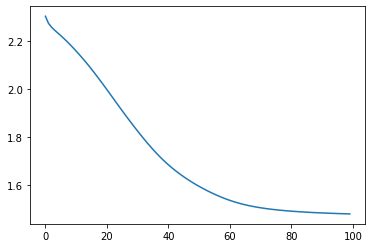

In [17]:
plt.plot(losses)
plt.show()

In [18]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [19]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [7.0717568e-03 9.6824372e-01 1.0486693e-02 1.9104435e-03 6.0859852e-04
 2.8201600e-03 1.7693198e-03 1.7478563e-03 5.2667097e-03 7.4706411e-05]
argmax를 한 후의 output은 1
accuracy는 0.9851851851851852


### 2. 추가 시도(1): 0.180
Activation Function = Sigmoid, lr = 0.4, Optimizer = Sgd, layer: 64-256-96-32-20-10, batch size = 10
- layer 수를 과하게 추가하면 심각한 성능 저하로 이어짐.
- Sgd Optimizer를 사용했을 시 Adam보다는 높은 학습률을 설정해야 accuracy를 높일 수 있음.

In [20]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [21]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size) 

In [22]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까? 
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
          nn.Linear(64,256, bias=True), 
          nn.Sigmoid(),
          nn.Linear(256,96, bias=True),
          nn.Sigmoid(),
          nn.Linear(96,32, bias=True),
          nn.Sigmoid(),
          nn.Linear(32,20, bias=True),
          nn.Sigmoid(),
          nn.Linear(32,20, bias=True), 
          nn.Softmax()
          ).to(device)

In [23]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64,256, bias=True), # input_layer = 30, hidden_layer1 = 398 
          nn.Sigmoid(),
        nn.BatchNorm1d(256)
    )
  # activation function 이용 
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함 
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 

    self.layer2 = nn.Sequential(
          nn.Linear(256,96, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(96,32, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
          nn.Linear(32,20, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer5 = nn.Sequential(
        nn.Linear(20, 10, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [24]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [25]:
model = Model().to('cuda')
model.apply(init_weights)

<ipython-input-24-6196a47a4462>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=96, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=96, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=32, out_features=20, bias=True)
    (1): Sigmoid()
  )
  (layer5): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [26]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=96, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=96, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=32, out_features=20, bias=True)
    (1): Sigmoid()
  )
  (layer5): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [27]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기


optimizer = optim.SGD(model.parameters(), lr=0.4, momentum=0.9)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [28]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 3.0230565071105957
10 2.6642613410949707
20 2.6171157360076904
30 2.614184856414795
40 2.6118903160095215
50 2.6056299209594727
60 2.584429979324341
70 2.5529682636260986
80 2.5178182125091553
90 2.487434148788452


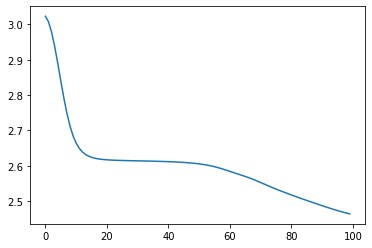

In [29]:
plt.plot(losses)
plt.show()

In [30]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [31]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.02511201 0.96296185 0.91518736 0.99520844 0.02272543 0.9879325
 0.07707392 0.15884174 0.98254955 0.9927859  0.00718358 0.00364751
 0.00408792 0.0075676  0.00434527 0.00607891 0.00453391 0.00517145
 0.00590696 0.00589742]
argmax를 한 후의 output은 3
accuracy는 0.1425925925925926


### 2. 추가 시도(2) : 0.987, Accuracy 가장 높은 시도
Activation Function = Relu, lr = 0.006, Optimizer = Adam, layer: 64-512-48-24-10
- layer의 개수 및 노드 수가 늘어날수록 Sigmoid와 ReLU의 성능 차이 발생하는 것으로 파악됨. (같은 조건에서 활성함수를 모두 Sigmoid로 변경하면 0.95 수준)
- Adam Optimizer의 경우 학습률을 높이는 것이 성능에 긍정적으로 작용하지 않는 듯함.

In [32]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [33]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size) 

In [34]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까? 
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
          nn.Linear(64,512, bias=True), 
          nn.ReLU(),
          nn.Linear(512,48, bias=True),
          nn.ReLU(),
          nn.Linear(48,24, bias=True),
          nn.Sigmoid(),
          nn.Linear(48,24, bias=True), 
          nn.Softmax()
          ).to(device)

In [35]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64,512, bias=True), # input_layer = 30, hidden_layer1 = 398 
          nn.Sigmoid(),
        nn.BatchNorm1d(512)
    )
  # activation function 이용 
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함 
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 

    self.layer2 = nn.Sequential(
          nn.Linear(512,48, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(48,24, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(24, 10, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [36]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.005)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [37]:
model = Model().to('cuda')
model.apply(init_weights)

<ipython-input-36-b0d97ce66a00>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=48, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=48, out_features=24, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=24, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [38]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=48, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=48, out_features=24, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=24, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [39]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기


optimizer = optim.Adam(model.parameters(), lr= 0.006)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [40]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 2.302907943725586
10 2.125934362411499
20 1.978169560432434
30 1.8431599140167236
40 1.7462273836135864


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


50 1.6809332370758057
60 1.6213123798370361
70 1.5613346099853516
80 1.5179235935211182
90 1.4952698945999146


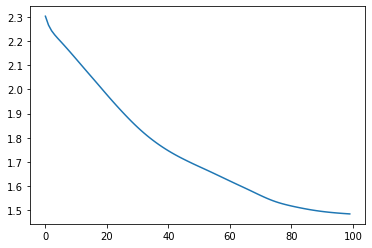

In [41]:
plt.plot(losses)
plt.show()

In [42]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [43]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [4.1470505e-04 9.7847956e-01 2.7619081e-03 1.7645246e-03 7.8640357e-03
 3.4478036e-04 6.8527652e-04 3.0345605e-03 3.9473246e-03 7.0334924e-04]
argmax를 한 후의 output은 1
accuracy는 0.987037037037037


# < 3주차 과제 2 : CNN 맛보기>

In [44]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [45]:
# Training settings

batch_size = 64

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [46]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
    self.mp = nn.MaxPool2d(2)
    self.fc = nn.Linear(320 , 10) ### : 알맞는 input은? 320!

  def forward(self, x):
    in_size = x.size(0)
    x = F.relu(self.mp(self.conv1(x)))
    x = F.relu(self.mp(self.conv2(x)))
    x = x.view(in_size, -1)
    x = self.fc(x)
    return F.log_softmax(x)

In [47]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)

In [48]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

In [49]:
def test():
    model.eval() #model.eval() 의 기능은? 
    # 모델 평가(evaluation) 모드로 전환하는 기능. Test set을 모델이 학습하지 않고 예측만 하도록 설정함.
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data # nll_loss?? / cross entropy loss와의 관계 확인! 
        # nll_loss는 이진 분류에서 음의 로그 우도로, cross entropy loss와 비교했을 때 softmax 부분이 빠져있다고 할 수 있음.
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [50]:
for epoch in range(1, 10):
    train(epoch)
    test()

<ipython-input-46-fc4d253827be>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304631
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.298917
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.289230
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.276697
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.266912
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.243018
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.242181
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.176081
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.077912
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.066079
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.868844
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.717011
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.402820
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.302919
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.992462
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.957060
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.779702
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.710733
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.690252
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.614448
Train Epoch: 1 [12800/60000 (

<ipython-input-49-2e9a1742d671>:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1856, Accuracy: 9436/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.207066
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.216108
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.354286
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.114324
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.160911
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.175837
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.228003
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.205816
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.276080
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.134030
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.236736
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.330650
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.105971
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.088248
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.097707
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.127805
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.174943
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.149159
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.078565
Train Epoch: 2 [12